In [1]:
import sys
import os

import scipy.ndimage
import xarray as xr
import matplotlib.pyplot as plt
sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))    # So can access functions in isca_tools which is in home/Isca directory
import isca_tools
import numpy as np
from isca_tools.utils.land import get_ocean_coords, get_land_coords
from isca_tools.utils import area_weighting, lat_lon_slice
from isca_tools.land import write_land
from isca_tools.run.create_files import write_var

2025-02-06 19:12:18,322 - isca - WARNING - Environment variable GFDL_SOC not set, but this is only required if using SocratesCodebase. Setting to None


In [2]:
isca_path = '/Users/joshduffield/Documents/StAndrews/Isca/jobs/'
exp_dir = 'rossbypalooza/sst_observation/test_vary_time/'

## Create land
Create zonal strip of land.

In [3]:
lat_min = 20
lat_max = 70
if not os.path.isfile(isca_path+exp_dir+'land.nc'):
    write_land(isca_path+exp_dir+'land', isca_path+exp_dir+'namelist.nml', 'square', [lat_min, lat_max, 0-10, 360+10])

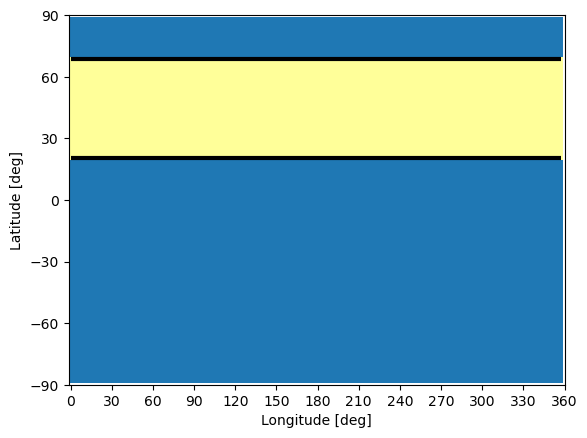

In [4]:
job_dir = os.path.join(os.path.dirname(os.environ['GFDL_DATA']), 'jobs')
land_file_name = os.path.join(job_dir, exp_dir, 'land.nc')
isca_tools.plot.show_land(land_file_name)

## Write SST file from observations
### Load in observations
Below, I smooth the Earth SST observations averaged from 1991-2020 to create an SST array

(0.0, 90.0)

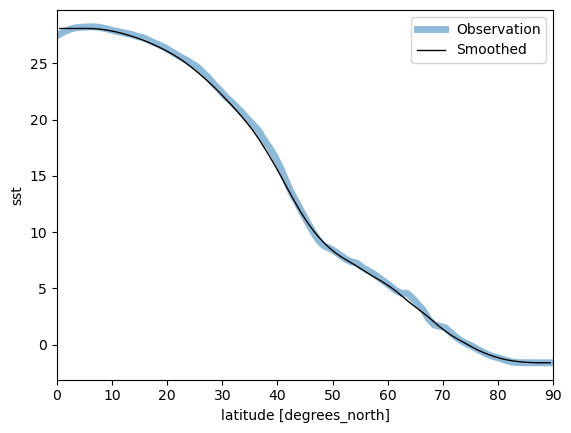

In [5]:
sst_obs = xr.load_dataset(isca_path+exp_dir+'sst.oisst.mon.ltm.1991-2020.nc', decode_times=False).mean(dim=['lon', 'time']).sst

# Smooth observations - only consider observations
sst_obs_smooth = scipy.ndimage.convolve1d(sst_obs, np.ones(10)/10, mode='nearest')[sst_obs.lat>0]
if sst_obs_smooth.argmax() != 0:
    sst_obs_smooth[:sst_obs_smooth.argmax()] = sst_obs_smooth.max()         # make equatorial value the same as the max value
sst_obs[sst_obs.lat>0].plot(lw=5, alpha=0.5, label='Observation')
plt.plot(sst_obs.lat[sst_obs.lat>0], sst_obs_smooth, lw=1, color='k', label='Smoothed')
plt.legend()
plt.xlim(0, 90)

### Save observations
Below, I interpolate the observed sst onto the lat-lon grid of resolution of the experiment. I then write this interpolated array to the experiment directory.

In [6]:
# Load in grid file of correct resolution, to get lat-lon info for simulation.
namelist = isca_tools.load_namelist(exp_dir, data_dir=job_dir, namelist_file='namelist.nml')
res_exp = int(namelist['experiment_details']['resolution'][1:])     # resolution for experiment read in
grid_dir = '/Users/joshduffield/Documents/StAndrews/Isca/isca_tools/run/grid_files/'
ds_res = xr.load_dataset(os.path.join(grid_dir, f"t{res_exp}_grid.nc"))

sst file already exists


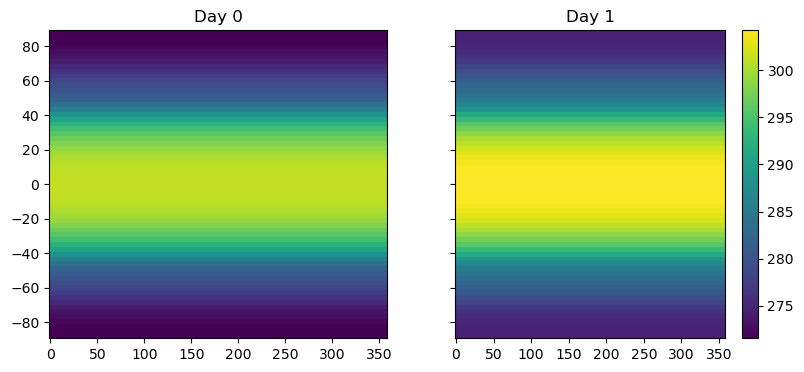

In [7]:
sst_obs_to_save = np.interp(np.abs(ds_res.lat), sst_obs.lat[sst_obs.lat>0], sst_obs_smooth)
sst_obs_to_save = np.tile(sst_obs_to_save[:, np.newaxis], [1, ds_res.lon.size])          # Add longitude axis
sst_obs_to_save = sst_obs_to_save + 273.15  # convert to kelvin
sst_obs_to_save = np.tile(sst_obs_to_save[np.newaxis], [2, 1, 1])   # add time dimension with 2 values
sst_obs_to_save[1] += 3       # every other day, add 3K

try:
    fig, ax = plt.subplots(1, 2, figsize=(0.8*12, 0.8*5), sharex=True, sharey=True)
    for i in range(2):
        im = ax[i].pcolormesh(ds_res.lon, ds_res.lat, sst_obs_to_save[i], vmin=sst_obs_to_save.min(), vmax=sst_obs_to_save.max())
        ax[i].set_title(f'Day {i}')
    plt.colorbar(im)
    write_var('sst', os.path.join(job_dir, exp_dir), var_array=sst_obs_to_save,
              lat_var=ds_res.lat.to_numpy(), lon_var=ds_res.lon.to_numpy(), time_var=np.arange(2), time_interpolate='wrap')
except ValueError:
    print('sst file already exists')

### Load in and plot saved SST

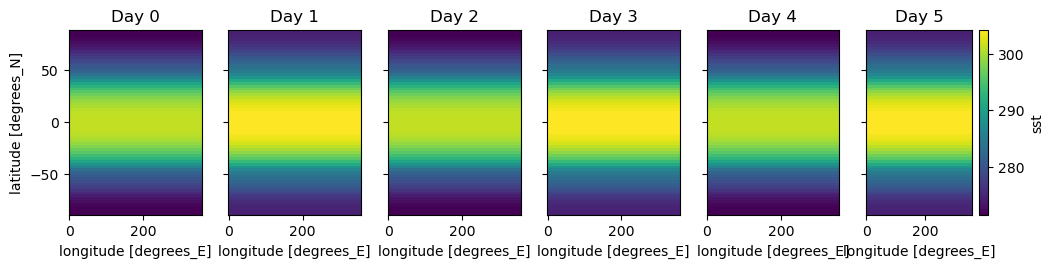

In [8]:
# Plot saved sst
sst_saved = xr.load_dataset(os.path.join(job_dir, exp_dir)+'sst.nc', decode_times=False).sst
fig, ax = plt.subplots(1, 6, figsize=(0.8*15, 0.8*3), sharex=True, sharey=True)
for i in range(6):
    sst_saved.isel(time=i).plot(ax=ax[i], vmin=sst_obs_to_save.min(), vmax=sst_obs_to_save.max(), add_colorbar=False if i<5 else True)
    ax[i].set_title(f'Day {i}')
    if i > 0:
        ax[i].set_ylabel(None)
plt.show()

## Sanity check that this is SST in simulation
In ocean only coordinates, we clearly don't match the above plot as expected. There seems to be an error.

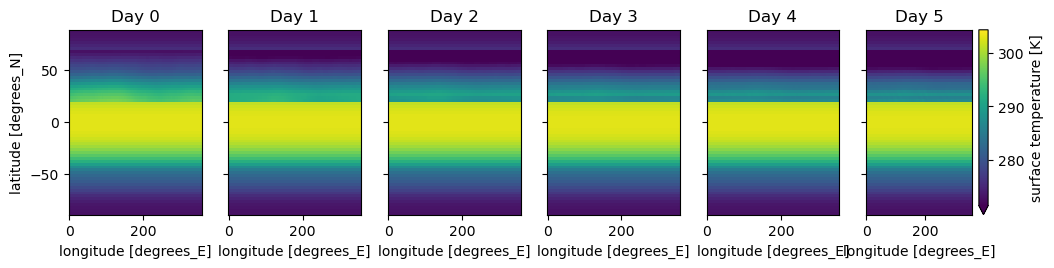

In [9]:
sst_sim = isca_tools.load_dataset(exp_dir)['t_surf']
fig, ax = plt.subplots(1, 6, figsize=(0.8*15, 0.8*3), sharex=True, sharey=True)
for i in range(6):
    sst_sim.isel(time=i).plot(ax=ax[i], vmin=sst_obs_to_save.min(), vmax=sst_obs_to_save.max(), add_colorbar=False if i<5 else True)
    ax[i].set_title(f'Day {i}')
    if i > 0:
        ax[i].set_ylabel(None)
plt.show()

Below we see that the simulated SST is 1.5K larger than the input SST on even days, and 1.5K smaller than the input SST on odd days. Clearly, the SST is just being set to the average of the two days. I guess this may have something to do with not being able to decode the time information.

In [25]:
lat_ocean = get_ocean_coords(land_file=os.path.join(job_dir,exp_dir,'land.nc'))[0]
lat_ocean = np.unique(lat_ocean)    # as land is zonal strip, we know all longitudes at each lat is land
for i in range(10):
    a = (sst_sim.sel(lat=lat_ocean, method='nearest').to_numpy() - sst_saved.sel(lat=lat_ocean, method='nearest')[:-1])[i]
    print(f'Day {i}: ', np.round(float(a.min()), 1), np.round(float(a.max()), 1))

Day 0:  1.5 1.5
Day 1:  -1.5 -1.5
Day 2:  1.5 1.5
Day 3:  -1.5 -1.5
Day 4:  1.5 1.5
Day 5:  -1.5 -1.5
Day 6:  1.5 1.5
Day 7:  -1.5 -1.5
Day 8:  1.5 1.5
Day 9:  -1.5 -1.5


In [26]:
xr.load_dataset(os.path.join(job_dir, exp_dir)+'sst.nc')

ValueError: Failed to decode variable 'time': unable to decode time units 'days since 0001-01-01 00:00:00' with "calendar 'THIRTY_DAY_MONTHS'". Try opening your dataset with decode_times=False or installing cftime if it is not installed.